# Алгоритмы интеллектуальной обработки больших объемов данных
## Котелевский Никита
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Котелевский".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} =(\sigma(<x_i,w>)-y_i)x_i  + \frac{sign(w_i)}{C}$$

## Имплементация (5 баллов)

In [3]:
#%%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10, error=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.error = error
        self.C = float(C)
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.L = list()

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.num_objects = X.shape[0]  # число объектов в выборке
        X_new = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))  # добавляем константный признак для w0
        self.num_features = X_new.shape[1]  # число фич в выборке
        w = np.random.uniform(-1. / self.num_objects, 1. / self.num_objects, self.num_features)  # инициализируем веса
        # рандомными значениями, близкими к 0
        y_new = np.copy(y)
        cur_epoch = 1
        cur_alpha = self.alpha
        while (cur_epoch <= self.max_epoch):
            per = np.random.permutation(X_new.shape[0])
            y_new = y_new[per]
            X_new = X_new[per]
            for i, x in enumerate(X_new):
                yh = y_new[i]
                L_dev = (self.sigma(np.dot(x, w)) - yh) * x
                L_dev += np.sign(w) * 1. / self.C
                w_new = w - L_dev * cur_alpha
                w = w_new
            L = self.loss(X_new, y_new, w)
            self.L.append(L)
            if (self.error):
                print L
            cur_epoch += 1
            cur_alpha = cur_alpha / (1. * cur_epoch)
        self.w = w
        return self

    def sigma(self, z):
        return 1. / (1 + np.exp(-z))

    def loss(self, X, y, w):
        s = self.sigma(np.dot(X, w))
        return -np.mean(y * np.log(s) + (1 - y) * np.log(1 - s))

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''

        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X_test = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
        y_hat = np.sum(X_test * self.w, axis=1)
        y_hat[y_hat >= 0] = 1
        y_hat[y_hat < 0] = 0
        return y_hat

    def w_(self):
        return self.w

    def score(self, X, y):
        return np.sum(y == self.predict(X), dtype=float) / X.shape[0]

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
        y_hat = self.sigma(np.dot(X, self.w))
        return y_hat

    def return_error(self):
        return self.L

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

In [5]:
my_clf = MySGDClassifier(C=100, max_epoch=20, alpha=0.1, error=True)
my_clf.fit(X, y)

0.3599446171061372
0.33750054849750766
0.33032166208535
0.3296838697869173
0.3289697621847952
0.32889514535180453
0.3288848763232586
0.3288836005013782
0.3288834588354765
0.3288834446723896
0.32888344338485836
0.32888344327756436
0.3288834432693109
0.32888344326872143
0.32888344326868213
0.32888344326867963
0.32888344326867947
0.3288834432686795
0.3288834432686795
0.3288834432686795


MySGDClassifier(C=100.0, alpha=0.1, error=True, max_epoch=20)

In [6]:
print my_clf.w_()

[-3.26152008  0.78580096 -0.75587413]


In [7]:
w = my_clf.w_()
x_t = np.array([-4, 6])
y_mine = -w[0] / w[2] - w[1] * x_t / w[2]

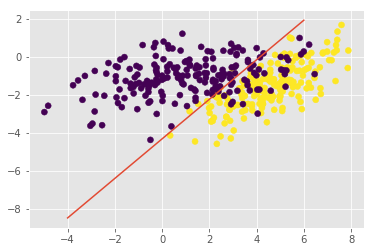

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.plot(x_t, y_mine)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [9]:
from sklearn.datasets import make_classification

In [10]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

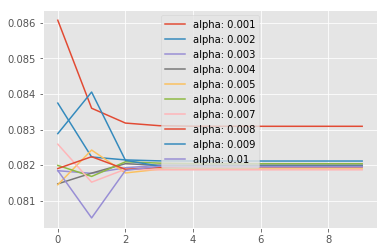

In [11]:
epoch = 10
for x in np.linspace(0.001, 0.01, 10):
    my_clf = MySGDClassifier(C=100, max_epoch=epoch, alpha=x)
    my_clf.fit(X, y)
    L = my_clf.return_error()
    plt.plot(np.arange(epoch), L, label='alpha: {}'.format(x))
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [12]:
## Your Code Here
w = []
for c in np.logspace(3, -3, 10):
    my_clf = MySGDClassifier(C=c, max_epoch=epoch, alpha=0.001)
    my_clf.fit(X, y)
    w.append(my_clf.w_())

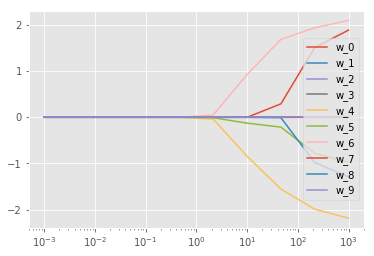

In [13]:
w_np = np.array(w)
for i in range(w_np.shape[0]):
    plt.plot(np.logspace(3, -3, 10), w_np[:, i], label='w_{}'.format(i))
    plt.xscale('log')
plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [35]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [36]:
df_data.shape

(500000, 45)

In [37]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [38]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [39]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [40]:
## Youd Code Here

In [41]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

unique = np.unique(np.hstack((df_data.opponent_hero_card_id.values, df_data.player_hero_card_id.values)))
le = LabelEncoder()
le.fit(unique)

print 'Количество уникальных карт: ', unique.shape[0]

oh = OneHotEncoder()
oh.fit(unique.reshape(-1, 1))

ohe = np.array(oh.transform(df_data.opponent_hero_card_id.values.reshape(-1, 1)).todense())
opponent = ohe
ohe = np.array(oh.transform(df_data.player_hero_card_id.values.reshape(-1, 1)).todense())
player = ohe

df_data = df_data.drop(columns=['player_hero_card_id', 'opponent_hero_card_id'], axis=1)

for i, s in enumerate(unique):
    df_data['player_card_id_' + str(s)] = player[:, i]
    df_data['opponent_card_id_' + str(s)] = opponent[:, i]

Количество уникальных карт:  9


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [21]:
y = df_data['decision']
X = df_data.drop(columns='decision')

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [23]:
pipe = Pipeline(
    [('StandartScaler', StandardScaler()),
     ('MySGDClassifier', MySGDClassifier(C=100, alpha=0.001, max_epoch=5))])
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('StandartScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('MySGDClassifier', MySGDClassifier(C=100.0, alpha=0.001, error=False, max_epoch=5))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [24]:
## Youd Code Here
df_list = []
for part in range(5, 8):
    filepath = './testData_tabular_chunk{}.csv'.format(part)
    df_list.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list)

df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [25]:
unique = np.unique(np.hstack((df_data_test.opponent_hero_card_id.values, df_data_test.player_hero_card_id.values)))
le = LabelEncoder()
le.fit(unique)

oh = OneHotEncoder()
oh.fit(unique.reshape(-1, 1))

ohe = np.array(oh.transform(df_data_test.opponent_hero_card_id.values.reshape(-1, 1)).todense())
opponent = ohe
ohe = np.array(oh.transform(df_data_test.player_hero_card_id.values.reshape(-1, 1)).todense())
player = ohe

df_data_test = df_data_test.drop(columns=['player_hero_card_id', 'opponent_hero_card_id'], axis=1)

for i, s in enumerate(unique):
    df_data_test['player_card_id_' + str(s)] = player[:, i]
    df_data_test['opponent_card_id_' + str(s)] = opponent[:, i]

In [26]:
from sklearn.metrics import roc_auc_score

y_test = np.loadtxt('deprecated_testLabels.txt')
X_test = df_data_test.iloc[:, 1:].values

y = pipe.predict_proba(X_test)

print 'ROC_AUC:', roc_auc_score(y_test, y)

ROC_AUC: 0.7889929537829238
